In [2]:
batch_size = 4
num_epochs = 25
image_size = 256

# Import Libaries

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch
import torch.optim as optim
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
text_data = pd.read_csv("/kaggle/input/flickr8k/captions.txt", sep="|")
text_data["number_of_words"] = text_data["caption_text"].apply(lambda text: len(text.split()))
text_data

,image_name,caption_number,caption_text,number_of_words
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...,18
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .,8
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .,9
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...,10
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...,13
...,...,...,...,...
40450,997722733_0cb5439472.jpg,0,A man in a pink shirt climbs a rock face,10
40451,997722733_0cb5439472.jpg,1,A man is rock climbing high in the air .,10
40452,997722733_0cb5439472.jpg,2,A person in a red shirt climbing up a rock fac...,16
40453,997722733_0cb5439472.jpg,3,A rock climber in a red shirt .,8


In [5]:
image_folder = '/kaggle/input/flickr8k/images'
image_filenames = os.listdir(image_folder)
image_filenames = [filename for filename in image_filenames if filename.endswith(('.jpg', '.png'))]

# image_filenames = image_filenames[0:100]

train_captions = []
test_captions = []
for image_filename in tqdm(image_filenames):
    caption = text_data[text_data['image_name']==image_filename].sort_values(by="number_of_words",ascending=False).reset_index(drop=True)['caption_text']
    train_caption = caption[0]
    test_caption = caption[1]
    train_captions.append( train_caption )
    test_captions.append( test_caption )

100%|██████████| 8091/8091 [01:00<00:00, 133.51it/s]


In [6]:
import os
# Get the number of available processors
num_processors = os.cpu_count()

# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, image_size=224):
        self.image_filenames = image_filenames
        self.captions = captions
        self.transform = transforms.Compose([
                                                transforms.Resize((image_size, image_size)),  # Resize images to a consistent size
                                                transforms.ToTensor(),          # Convert images to tensors
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
                                            ])
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image = Image.open("/kaggle/input/flickr8k/images/"+image_filenames[index])
        image = self.transform(image) # .permute(2,1,0)
        text = self.captions[index]
        
        return image, text

# Create an instance of the dataset
train_dataset = ImageTextDataset(image_filenames, train_captions, image_size)
test_dataset = ImageTextDataset(image_filenames, test_captions, image_size)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=True
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*16, shuffle=False ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=False

In [61]:
i=0
train_dataset.__getitem__(i)[0].shape, train_dataset.__getitem__(i)[1]

(torch.Size([3, 256, 256]),
 'A white and brown spotted dog runs along the snow to catch a ball .')

# Display Few Image with Caption

In [62]:
# Fetch a batch from the dataloader
batch_images, batch_texts = next(iter(train_dataloader))



In [63]:
batch_images.shape


torch.Size([4, 3, 256, 256])

In [64]:
batch_texts

('A man in a tank top stands next to a chrome door .',
 'Asian girl with white tank top and pink shorts running through grass .',
 'A mountain biker is riding along a heavy dirt trail in a wooded area .',
 'a beagle and a golden retriever wrestling in the grass')

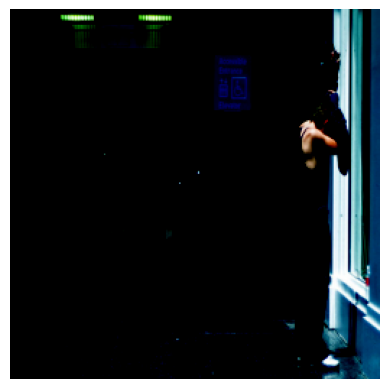

Caption: A man in a tank top stands next to a chrome door . 





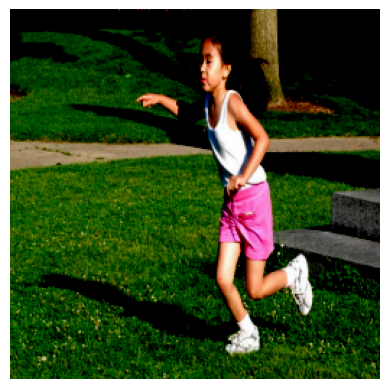

Caption: Asian girl with white tank top and pink shorts running through grass . 





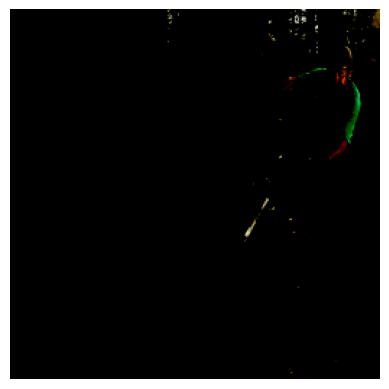

Caption: A mountain biker is riding along a heavy dirt trail in a wooded area . 





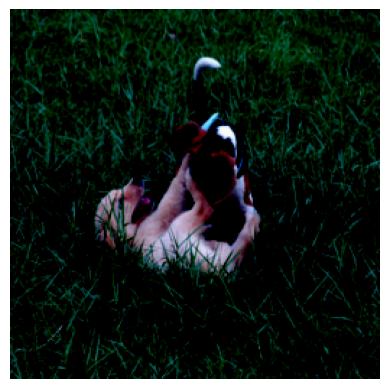

Caption: a beagle and a golden retriever wrestling in the grass 





In [65]:
for index in range(batch_images.shape[0]):
    # Fetch the image and text for the chosen index
    image_to_display = batch_images[index]
    text_to_display = batch_texts[index]

    # Convert the image tensor to a NumPy array
    image_to_display_np = image_to_display.permute(1, 2, 0).numpy()

    # Display the image using matplotlib
    plt.imshow(image_to_display_np)
    plt.axis('off')  # Turn off axis labels
    plt.show()

    # Display the corresponding text
    print("Caption:", text_to_display, "\n\n\n")
    if index>=5:
        break

In [7]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name) # DistilBertTokenizer.from_pretrained(model_name) 
model = DistilBertModel.from_pretrained(model_name)

def generate_text_embeddings(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings from the last hidden layer
    embeddings = outputs.last_hidden_state[:, 0, :] # <---CLS # outputs.last_hidden_state.mean(dim=1)  # You can use other aggregation methods

    return embeddings

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [71]:
# List of input texts
texts = [ "yo yo CLIP Model", "DistilBERT is a great model for text embedding.", "Vision Transformers for image.", "Contrative Learning" ]

# Generate embeddings
embeddings = generate_text_embeddings(texts)
print("Shape of embeddings:", embeddings.shape)  # Should print (num_texts, embedding_size)

Shape of embeddings: torch.Size([4, 768])


# Model Implementation

In [19]:
import torch
import torch.nn as nn

dropout = 0.2

class ImageProjection(nn.Module):
    def __init__(self, image_embedding_size, shared_embedding_size):
        super(ImageProjection, self).__init__()
        self.image_projection = nn.Linear(image_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)
        
    def forward(self, image_embeddings):
        projected_embeddings = self.image_projection(image_embeddings)
        
        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)
        
        # Normalize the embeddings
        normalized_embeddings = torch.nn.functional.normalize(x, p=2, dim=-1)
        
        return normalized_embeddings

class TextProjection(nn.Module):
    def __init__(self, text_embedding_size, shared_embedding_size):
        super(TextProjection, self).__init__()
        self.text_projection = nn.Linear(text_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)
        
    def forward(self, text_embeddings):
        projected_embeddings = self.text_projection(text_embeddings)
        
        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)
        
        # Normalize the embeddings
        normalized_embeddings = torch.nn.functional.normalize(x, p=2, dim=-1)
        
        return normalized_embeddings


batch_idx:  0  Image Shape:  torch.Size([4, 3, 256, 256]) Text Count:  4


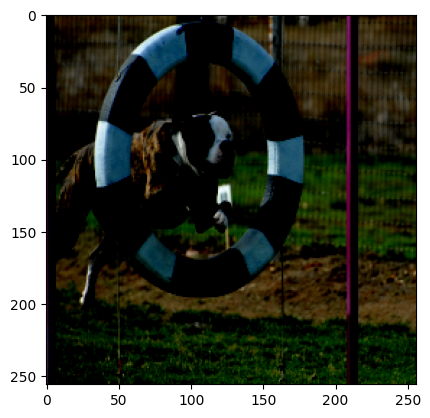

A black and white dog is jumping through a black and white hoop .


In [9]:
import os

# Set the environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "true" 

# Checking Data Setup
for batch_idx, (images, texts) in enumerate(train_dataloader):
    print( "batch_idx: ", batch_idx, " Image Shape: ", images.shape, "Text Count: ", len(texts) )
    plt.imshow( torch.moveaxis( images[0], 0, 2 ).numpy() )
    plt.show()
    print(texts[0])
    break

In [10]:
dropout = 0.2

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

temperature_value = nn.Parameter(torch.tensor(1.0), requires_grad=True)

def contrastive_clip_loss_function( text_projection,  image_projection, mode="eval" ):
    logits = (text_projection @ image_projection.T) / temperature_value
    if mode=="train":
        images_similarity = image_projection @ image_projection.T
        texts_similarity = text_projection @ text_projection.T
        targets = F.softmax( (images_similarity + texts_similarity) / 2 * temperature_value, dim=-1 )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()
    elif mode=="eval":
        return logits
    else:
        print("Mention mode")
        return None

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time

# Training Model - ResNet50 + Distil BERT

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:

shared_embedding_size = 512  
# learning_rate = 5e-4

image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)

max_length = 32
text_embedding_size = 768 
model_name = 'distilbert-base-uncased'
text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) # .to(device)
text_model = DistilBertModel.from_pretrained(model_name ).to(device)

image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)

params = [{"params":resnet_model.parameters(), "lr":1e-4 }, {"params":text_model.parameters(), "lr":1e-5}, 
          # {"params":image_projector.parameters(), "lr": }, {"params":text_projector.parameters(), "lr":}
          {"params": itertools.chain( image_projector.parameters(), text_projector.parameters() , [temperature_value]), "lr":1e-3 , "weight_decay":1e-3 }
         ]
optimizer = optim.AdamW( params,  weight_decay=0. )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=2 , factor=0.8 )


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s] 


In [14]:
import torch

# Load the saved model checkpoint
checkpoint_path = "/kaggle/input/temp1-432resnetbert/final_odel_from_Scratch_ResNet_DistilBERT.h5"
checkpoint = torch.load(checkpoint_path)


# Load the state dictionaries into the models and optimizer
resnet_model.load_state_dict(checkpoint['resnet_model_dict'])
text_model.load_state_dict(checkpoint['text_model_dict'])
image_projector.load_state_dict(checkpoint['image_projector_dict'])
text_projector.load_state_dict(checkpoint['text_projector_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the models to evaluation mode

image_projector.eval()




ImageProjection(
  (image_projection): Linear(in_features=2048, out_features=512, bias=True)
  (gelu): GELU(approximate='none')
  (fc): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

In [15]:
resnet_model.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [16]:
text_model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [17]:
text_projector.eval()

TextProjection(
  (text_projection): Linear(in_features=768, out_features=512, bias=True)
  (gelu): GELU(approximate='none')
  (fc): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

In [82]:
import matplotlib.pyplot as plt

# List to store the training losses
train_losses = []
num_epochs=2
# - - - - - - - - -  Training loop  - - - - - - - - -
for epoch in range(num_epochs):
    # Record the start time
    start_time = time.time()
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    resnet_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0
    total_images_processed = 0
    for batch_idx, (images, texts) in enumerate(train_dataloader):
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        optimizer.zero_grad()
        
        # - - - -  Text  - - - - 
        inputs = tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :] # outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - - 
        images = images.to(device)
        # images = preprocess_images(images)
        image_embeddings = resnet_model(images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # - - - -  Compute Loss  - - - -
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")
        
        # - - - -  Backpropagation  - - - -
        loss.backward()
        optimizer.step()

        # - - - - Loss print - - - -
        total_loss += loss.item()
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")
    
    
    lr_scheduler.step(total_loss)
    
    # Record the end time
    end_time = time.time()
    elapsed_time = end_time - start_time
    # - - - - Loss each epoch
    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}", "  Time Taken: ", elapsed_time, " seconds" )

 - - - - - - - - - - - Epoch: 1  - - - - - - - - - - - - 
Epoch [1/2], Batch [0/2023], Loss: 0.0014
Epoch [1/2], Batch [200/2023], Loss: 0.0106
Epoch [1/2], Batch [400/2023], Loss: 0.0112
Epoch [1/2], Batch [600/2023], Loss: 0.0102
Epoch [1/2], Batch [800/2023], Loss: 0.0110
Epoch [1/2], Batch [1000/2023], Loss: 0.0106
Epoch [1/2], Batch [1200/2023], Loss: 0.0116
Epoch [1/2], Batch [1400/2023], Loss: 0.0116
Epoch [1/2], Batch [1600/2023], Loss: 0.0112
Epoch [1/2], Batch [1800/2023], Loss: 0.0112
Epoch [1/2], Batch [2000/2023], Loss: 0.0119
Epoch [1/2], Average Loss: 0.0474   Time Taken:  205.00493550300598  seconds
 - - - - - - - - - - - Epoch: 2  - - - - - - - - - - - - 
Epoch [2/2], Batch [0/2023], Loss: 0.0515
Epoch [2/2], Batch [200/2023], Loss: 0.0085
Epoch [2/2], Batch [400/2023], Loss: 0.0112
Epoch [2/2], Batch [600/2023], Loss: 0.0118
Epoch [2/2], Batch [800/2023], Loss: 0.0108
Epoch [2/2], Batch [1000/2023], Loss: 0.0115
Epoch [2/2], Batch [1200/2023], Loss: 0.0114
Epoch [2/2]

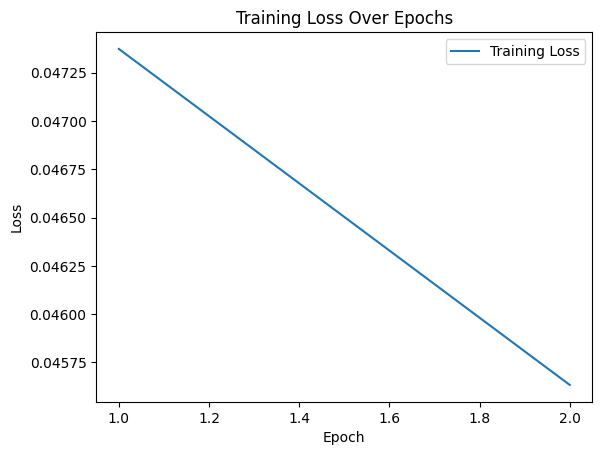

In [84]:
# Plot the training loss graph
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [85]:
resnet_model.eval()
image_projector.eval()

def create_image_embeddings(images):
    with torch.no_grad():
        image_embeddings = resnet_model(images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
    return image_projection

image_embeddings_list_train = []

for index in tqdm(range(len( train_dataset ))):
    images = train_dataset[index][0]
    images = images.to(device)
    image_projection = create_image_embeddings(images.unsqueeze(0))
    image_embeddings_list_train.append( image_projection[0] )
    
    
def image_retrieval_function( input_query, n , display=False): # n --> number of images
    with torch.no_grad():
        inputs = tokenizer(input_query, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
    
    similarity_scores_list = []
    for index in tqdm(range(len(image_embeddings_list_train))):
        score = torch.dot( text_projection[0], image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )
    
    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]
    if display:
        for index in max_indexes:
            image_tensor = train_dataset[index][0]
            plt.imshow( torch.moveaxis(image_tensor, 0,2) )
            plt.show()
        return None
    else:
        return max_indexes

100%|██████████| 8091/8091 [02:09<00:00, 62.50it/s]


100%|██████████| 8091/8091 [00:00<00:00, 17373.09it/s]


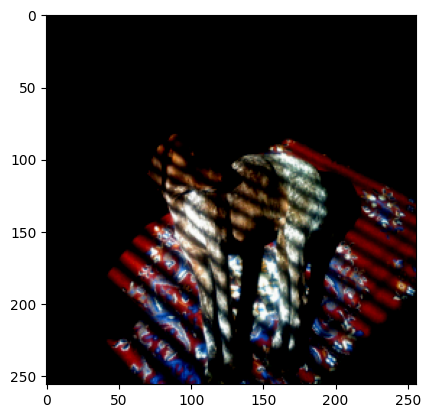

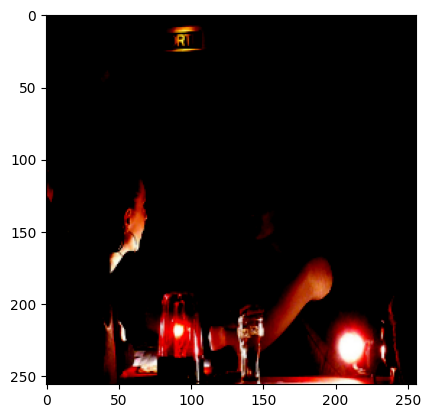

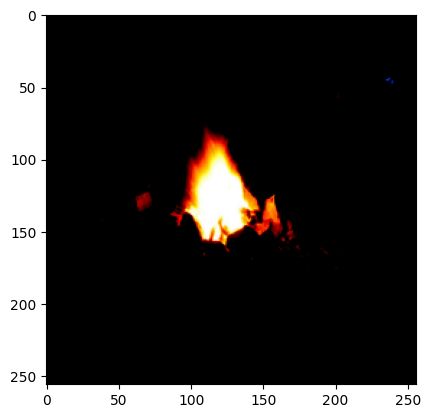

In [86]:
input_query = "fire"
image_retrieval_function( input_query, n=3, display=True )

100%|██████████| 8091/8091 [00:00<00:00, 18340.82it/s]


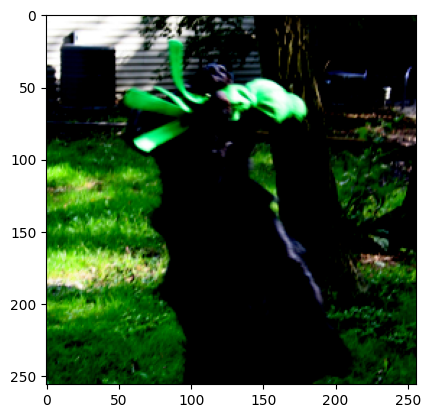

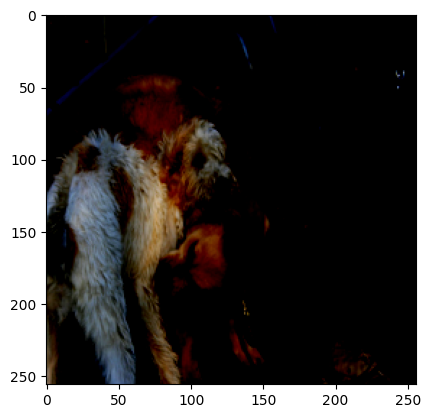

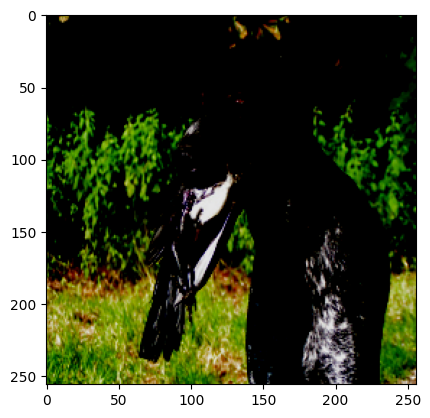

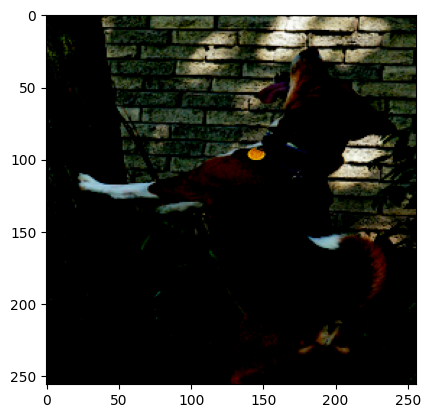

In [87]:
input_query = "a photo of dog"
image_retrieval_function( input_query, n=4, display=True )

100%|██████████| 8091/8091 [00:00<00:00, 17028.64it/s]


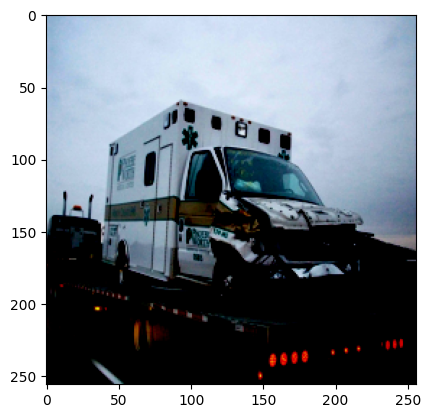

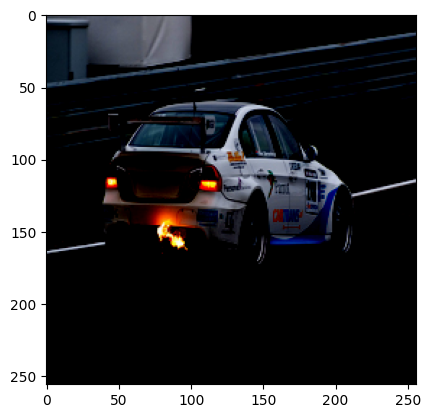

In [88]:
input_query = "car"
image_retrieval_function( input_query, n=2, display=True )

100%|██████████| 8091/8091 [00:00<00:00, 17567.79it/s]


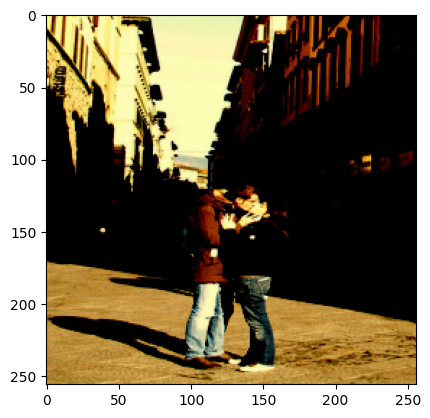

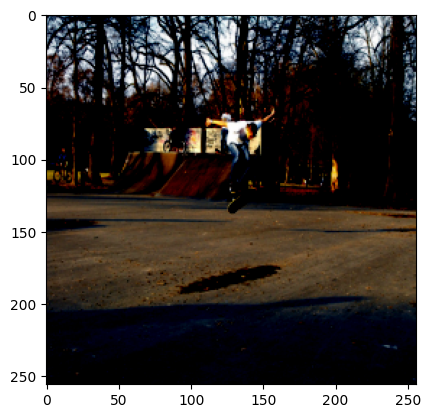

In [89]:
input_query = "road"
image_retrieval_function( input_query, n=2, display=True )

# Evaluation | Testing

accuracy too low

Take a video extract its audio, get it transripted the audio using whisper etc .. put subitile for every second , 
Store the transcription along with the corresponding timestamps. Ensure that each phrase in the transcription is associated with its respective timestamp in the video.
When a user submits a query like "When does it say curl?", process the query to identify the specific keywords or phrases (e.g., "curl") for which the user is seeking timestamps.

In [94]:
R_at_1_counter = 0

with torch.no_grad():
    for batch_images, batch_captions in tqdm(test_dataloader):
        batch_size = batch_images.size(0)
        
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - - 
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - -  
        batch_images = batch_images.to(device)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot(text_projection[index_text], image_projection[index_image])
                similarity_scores_list.append(score.cpu().numpy())
            similarity_scores_list = np.array(similarity_scores_list)
        
            top_indices = np.argsort(similarity_scores_list)[-1:] 
            if index_text in top_indices:
                R_at_1_counter += 1

total_samples = len(test_dataloader.dataset)
R_at_1 = R_at_1_counter / total_samples
print(f"R@1 (Recall at 1): {R_at_1*100:.4f}%")


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]

R@1 (Recall at 1): 82.8328%


In [95]:
R_at_5_counter = 0

with torch.no_grad():
    for batch_images, batch_captions in tqdm(test_dataloader):
        batch_size = batch_images.size(0)
        
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - - 
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - -  
        batch_images = batch_images.to(device)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot(text_projection[index_text], image_projection[index_image])
                similarity_scores_list.append(score.cpu().numpy())
            similarity_scores_list = np.array(similarity_scores_list)
        
            top_indices = np.argsort(similarity_scores_list)[-5:]  # Get indices of top 5 scores
            if index_text in top_indices:
                R_at_5_counter += 1

total_samples = len(test_dataloader.dataset)
R_at_5 = R_at_5_counter / total_samples
print(f"R@5 (Recall at 5): {R_at_5*100:.4f}%")


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]

R@5 (Recall at 5): 94.6855%


In [96]:
R_at_10_counter = 0

with torch.no_grad():
    for batch_images, batch_captions in tqdm(test_dataloader):
        batch_size = batch_images.size(0)
        
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - - 
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - -  
        batch_images = batch_images.to(device)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot(text_projection[index_text], image_projection[index_image])
                similarity_scores_list.append(score.cpu().numpy())
            similarity_scores_list = np.array(similarity_scores_list)
        
            top_indices = np.argsort(similarity_scores_list)[-10:]  # Get indices of top 5 scores
            if index_text in top_indices:
                R_at_10_counter += 1

total_samples = len(test_dataloader.dataset)
R_at_10 = R_at_10_counter / total_samples
print(f"R@10 (Recall at 10):: {R_at_10*100:.4f}%")


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]

R@10 (Recall at 10):: 97.3304%


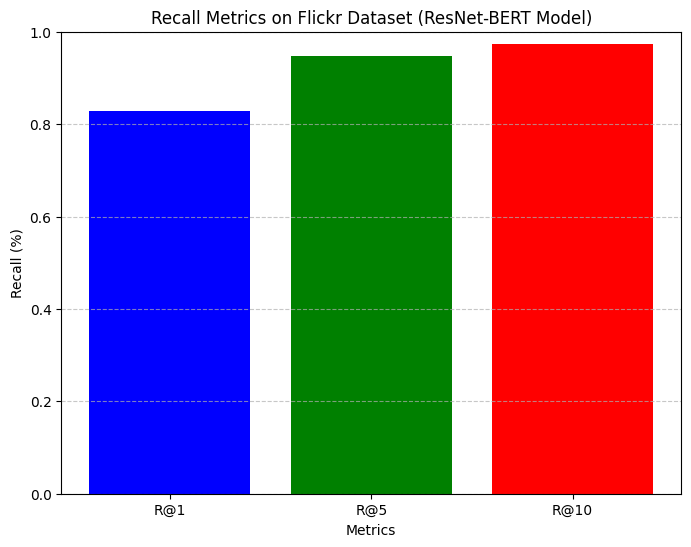

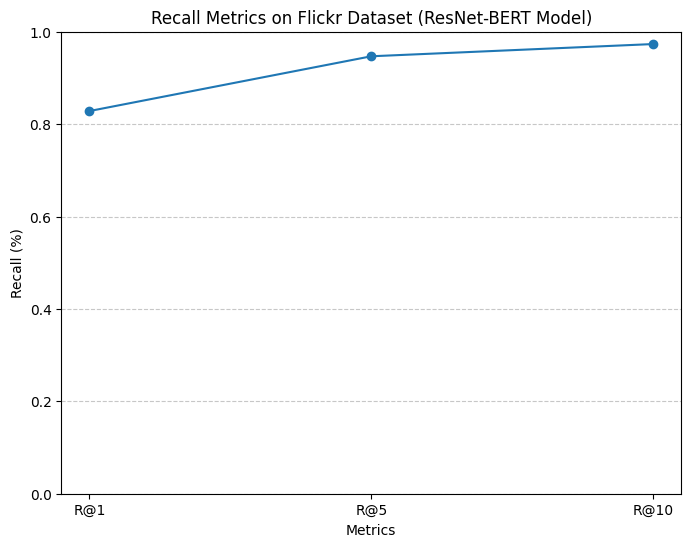

In [99]:
import numpy as np
import matplotlib.pyplot as plt



# Bar plot
labels = ['R@1', 'R@5', 'R@10']
values = [R_at_1, R_at_5, R_at_10]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Recall (%)')
plt.title('Recall Metrics on Flickr Dataset (ResNet-BERT Model)')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Line plot
x = np.arange(len(labels))
plt.figure(figsize=(8, 6))
plt.plot(x, values, marker='o', linestyle='-')
plt.xticks(x, labels)
plt.xlabel('Metrics')
plt.ylabel('Recall (%)')
plt.title('Recall Metrics on Flickr Dataset (ResNet-BERT Model)')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [21]:
# import matplotlib.pyplot as plt

# # List to store similarity scores
# similarity_scores_list = []

# # Testing loop
# with torch.no_grad():
#     for batch_images, batch_captions in tqdm(test_dataloader):
#         batch_size = batch_images.size(0)
        
#         # - - - - - - - - -  Forward pass  - - - - - - - - -
#         # - - - -  Text  - - - - 
#         inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
#         inputs = inputs.to(device)
#         outputs = text_model(**inputs)
#         text_embeddings = outputs.last_hidden_state.mean(dim=1)
#         text_projection = text_projector(text_embeddings)
        
#         # - - - -  Image  - - - -  
#         batch_images = batch_images.to(device)
#         image_embeddings = resnet_model(batch_images)
#         image_projection = image_projector(image_embeddings[:,:,0,0])
        
#         # Calculate cosine similarities
#         for index_text in range(batch_size):
#             for index_image in range(len(image_projection)):
#                 score = torch.dot(text_projection[index_text], image_projection[index_image])
#                 similarity_scores_list.append(score.cpu().numpy())

# # Plot the similarity scores graph
# fig_width = 15  # Three times the height
# fig_height = 5
# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(similarity_scores_list)
# plt.xlabel('Sample Index')
# plt.ylabel('Similarity Score')
# plt.title('Similarity Scores Distribution')
# plt.show()
